Densenet121_2   Densenet121_64 2

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Import NumPy to handle array's and Matplotlib for plotting loss curves
import numpy as np
import matplotlib.pyplot as plt
import random
# Import TensorFlow and relevant Keras classes to setup the model
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
#from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.applications.densenet import DenseNet169, DenseNet201, DenseNet121
from tensorflow.keras.layers import Input, Flatten, Dense, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, Concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import losses, optimizers, activations, metrics

In [0]:
import tensorflow_datasets as tfds
#download=False - if you dont want to download data again
pcam, pcam_info = tfds.load("patch_camelyon", data_dir='/content/drive/My Drive/Colab Notebooks',download=False, with_info=True) 
#print(pcam_info)

In [0]:
#densenet.summary()

In [15]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
densenet = DenseNet121(
    weights= 'imagenet',
    include_top=False,
    input_shape=(96,96,3)
)

densenet.trainable = False

def build_model():
    model = Sequential()
    model.add(densenet)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1024, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = "softmax"))
    
    sgd_opt = SGD(lr=0.001)
    #sgd_opt = SGD(lr=0.001, momentum=0.9, decay=0.1, nesterov=True)
    model.compile(
        loss='binary_crossentropy',
        optimizer=sgd_opt,#Adam(lr=0.0005,),
        metrics=['accuracy']
    )
    
    return model

model = build_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 3, 3, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1048576   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                

In [0]:
def convert_sample(sample):
    image, label = sample['image'], sample['label']  
    image = tf.image.convert_image_dtype(image, tf.float32)
    #image = tf.image.rgb_to_grayscale(image)
    image = tf.image.rot90(image, random.randint(0,1))
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    label = tf.one_hot(label, 2, dtype=tf.float32)
    return image, label

train_pipeline = pcam['train'].map(convert_sample,
                                   num_parallel_calls=8).shuffle(1024).repeat().batch(64).prefetch(2)
valid_pipeline = pcam['validation'].map(convert_sample,
                                        num_parallel_calls=8).repeat().batch(128).prefetch(2)

In [17]:
hist = model.fit(train_pipeline,
                 validation_data=valid_pipeline,
                 verbose=2, epochs=30, steps_per_epoch=4096, validation_steps=256)#, callbacks=[callback])

Epoch 1/30
4096/4096 - 153s - loss: 0.4853 - accuracy: 0.7826 - val_loss: 0.3984 - val_accuracy: 0.8135
Epoch 2/30
4096/4096 - 152s - loss: 0.3996 - accuracy: 0.8230 - val_loss: 0.3870 - val_accuracy: 0.8216
Epoch 3/30
4096/4096 - 145s - loss: 0.3801 - accuracy: 0.8314 - val_loss: 0.3862 - val_accuracy: 0.8235
Epoch 4/30
4096/4096 - 167s - loss: 0.3676 - accuracy: 0.8380 - val_loss: 0.3826 - val_accuracy: 0.8240
Epoch 5/30
4096/4096 - 174s - loss: 0.3634 - accuracy: 0.8398 - val_loss: 0.3805 - val_accuracy: 0.8252
Epoch 6/30
4096/4096 - 174s - loss: 0.3558 - accuracy: 0.8435 - val_loss: 0.3801 - val_accuracy: 0.8265
Epoch 7/30
4096/4096 - 171s - loss: 0.3531 - accuracy: 0.8447 - val_loss: 0.3782 - val_accuracy: 0.8255
Epoch 8/30
4096/4096 - 187s - loss: 0.3504 - accuracy: 0.8471 - val_loss: 0.3759 - val_accuracy: 0.8289
Epoch 9/30
4096/4096 - 149s - loss: 0.3467 - accuracy: 0.8480 - val_loss: 0.3760 - val_accuracy: 0.8275
Epoch 10/30
4096/4096 - 161s - loss: 0.3427 - accuracy: 0.8504 -

In [18]:
test_pipeline = pcam['test'].map(convert_sample, num_parallel_calls=8).batch(128).prefetch(2)
print("Test set accuracy is {0:.4f}".format(model.evaluate(test_pipeline, steps=256, verbose=0)[1]))

Test set accuracy is 0.8194


In [19]:
model.save("./saved_models/freeze")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: ./saved_models/freeze/assets


INFO:tensorflow:Assets written to: ./saved_models/freeze/assets


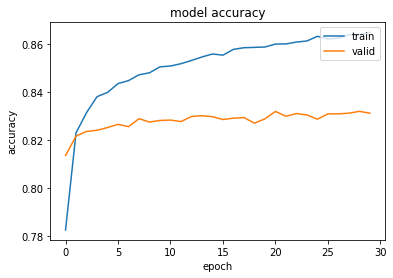

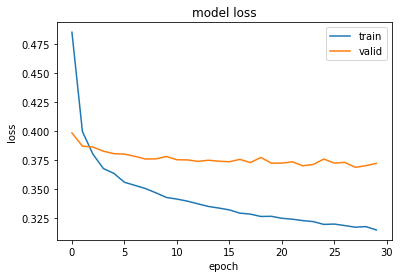

In [20]:
hist2=hist
plt.figure()
plt.plot(hist2.history['accuracy'])
plt.plot(hist2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

# summarize history for loss
plt.figure()
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [21]:
#Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from keras import optimizers
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
%matplotlib inline
sns.set_style("whitegrid")
np.random.seed(697)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [22]:
# Code below from https://www.kaggle.com/georsara1/95-auc-score-in-train-sample-with-neural-nets

#Predict on test set
predictions_NN_prob = model.predict(test_pipeline)
predictions_NN_prob = predictions_NN_prob[:,0]

predictions_NN_01 = np.where(predictions_NN_prob > 0.5, 0, 1) #Turn probability to 0-1 binary output

y_numpy = pcam['test'].as_numpy_iterator()
test_y = np.array([i['label'] for i in y_numpy])


acc_NN = accuracy_score(test_y, predictions_NN_01)
print('Overall accuracy of Neural Network model:', acc_NN)

Overall accuracy of Neural Network model: 0.820526123046875


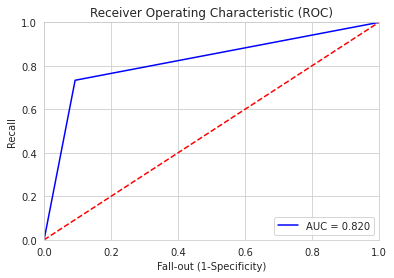

In [23]:

#Print Area Under Curve
false_positive_rate, recall, thresholds = roc_curve(test_y, predictions_NN_01)
roc_auc = auc(false_positive_rate, recall)
plt.figure()
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

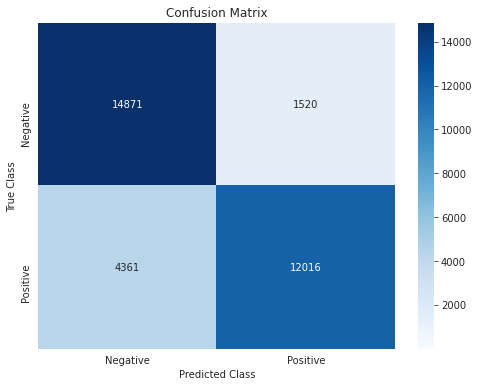

In [24]:
#Print Confusion Matrix
cm = confusion_matrix(test_y, predictions_NN_01)
labels = ['Negative', 'Positive']
plt.figure(figsize=(8,6))
sns.heatmap(cm,xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

Overall accuracy of Neural Network model: 0.819671630859375


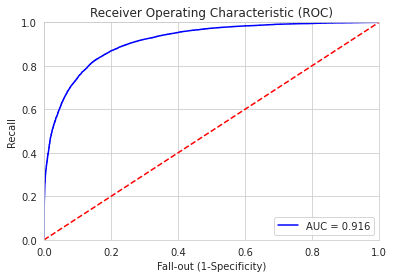

In [26]:
#Predict on test set
predictions_NN_prob = model.predict(test_pipeline)
predictions_NN_prob = predictions_NN_prob[:,1]

predictions_NN_01 = np.where(predictions_NN_prob > 0.5, 1, 0) #Turn probability to 0-1 binary output

y_numpy = pcam['test'].as_numpy_iterator()
test_y = np.array([i['label'] for i in y_numpy])

#Print accuracy
acc_NN = accuracy_score(test_y, predictions_NN_01)
print('Overall accuracy of Neural Network model:', acc_NN)
#Print Area Under Curve
false_positive_rate, recall, thresholds = roc_curve(test_y, predictions_NN_prob)
roc_auc = auc(false_positive_rate, recall)
plt.figure()
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

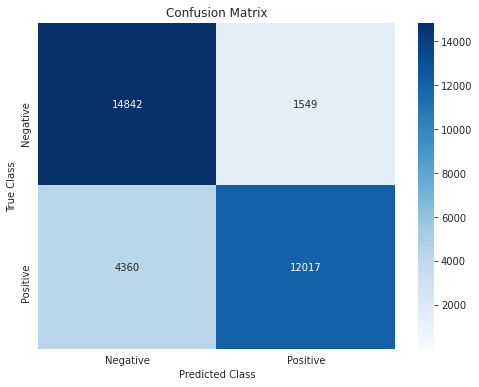

In [27]:
#Print Confusion Matrix
cm = confusion_matrix(test_y, predictions_NN_01)
labels = ['Negative', 'Positive']
plt.figure(figsize=(8,6))
sns.heatmap(cm,xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()